In [1]:
%pip install pybullet
%pip install control

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [4]:
import pybullet as p
import numpy as np
from control.matlab import place, lqr

dt = 1/240
th0 =  np.pi-np.deg2rad(10)
thd = np.pi
jIdx = 1
e_int = 0
e_prev = 0
maxTime = 10
logTime = np.arange(0.0, maxTime, dt)
sz = len(logTime)
logPos = np.zeros(sz)
logPos[0] = th0
logVel = np.zeros(sz)
logCtrl = np.zeros(sz)
idx = 0
u = 0

g = 10
L = 0.5
m = 1
kf = 0.5
a = -g/L
b = -1/(m*L*L)
c = kf*b

A = np.array([[0, 1],
            [a, c]])
B = np.array(([0], [b]))


Q = np.diag([10,1])
R = 0.01
K, *_ = lqr(A, B, Q, R)
K = -K
print(f"lqr: {K}")
print(f"poles lqr:{np.linalg.eig(A+B@K)}")


lqr: [[27.01562119 10.16573066]]
poles lqr:EigResult(eigenvalues=array([ -3.24918388, -39.41373877]), eigenvectors=array([[ 0.29415333, -0.0253637 ],
       [-0.95575824,  0.99967829]]))


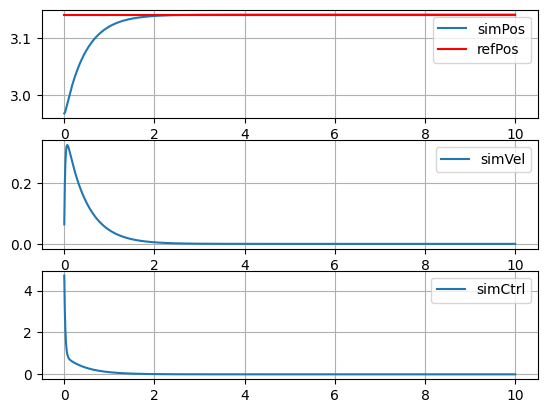

In [5]:
physicsClient = p.connect(p.DIRECT) # or p.DIRECT for non-graphical version
p.setGravity(0,0,-10)
boxId = p.loadURDF("./pendulum.urdf", useFixedBase=True)

# turn off internal damping
p.changeDynamics(boxId, 1, linearDamping=0, angularDamping=0)

# go to the starting position
p.setJointMotorControl2(bodyIndex=boxId, jointIndex=jIdx, targetPosition=th0, controlMode=p.POSITION_CONTROL)
for _ in range(1000):
    p.stepSimulation()

# turn off the motor for the free motion
p.setJointMotorControl2(bodyIndex=boxId, jointIndex=jIdx, targetVelocity=0, controlMode=p.VELOCITY_CONTROL, force=0)
for t in logTime[1:]:
    # p.setJointMotorControl2(bodyIndex=boxId, jointIndex=jIdx, controlMode=p.TORQUE_CONTROL, force=f)
    jointState = p.getJointState(boxId, jIdx)
    th1 = jointState[0]
    dth1 = jointState[1]
    e = th1-thd
    ed = (e-e_prev)/dt
    e_int += e*dt
    e_prev = e
    #u = -kp*e - ki*e_int - kd*ed
    u = -K[0,0]*e - K[0,1]*dth1
    logCtrl[idx] = u
    # p.setJointMotorControl2(
    #     bodyIndex=boxId,
    #     jointIndex=jIdx,
    #     controlMode=p.VELOCITY_CONTROL,
    #     targetVelocity=u
    # )

    p.setJointMotorControl2(
        bodyIndex=boxId,
        jointIndex=jIdx,
        controlMode=p.TORQUE_CONTROL,
        force=u
    )

    p.stepSimulation()

    jointState = p.getJointState(boxId, jIdx)
    th1 = jointState[0]
    dth1 = jointState[1]
    logVel[idx] = dth1
    idx += 1
    logPos[idx] = th1

logVel[idx] = p.getJointState(boxId, jIdx)[1]
logCtrl[idx] = u

# setTempLvl(lvl) [0-100]
# t = getTemperature()
# e = t-t_d
# u = -10*e
# setTemplLvl(u)

import matplotlib.pyplot as plt

plt.subplot(3,1,1)
plt.grid(True)
plt.plot(logTime, logPos, label = "simPos")
plt.plot([logTime[0],logTime[-1]],[thd,thd],'r', label='refPos')
plt.legend()

plt.subplot(3,1,2)
plt.grid(True)
plt.plot(logTime, logVel, label = "simVel")
plt.legend()

plt.subplot(3,1,3)
plt.grid(True)
plt.plot(logTime, logCtrl, label = "simCtrl")
plt.legend()

plt.show()

p.disconnect()